<a href="https://colab.research.google.com/github/wangyu16/PolymerScienceEducation/blob/master/OVESET/04_ATRP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<center><a href="https://wangyu16.github.io/PolymerScienceEducation/"><img src="https://raw.githubusercontent.com/wangyu16/PolymerScienceEducation/master/Fig/Logo_black.svg" width='150' /></a></center>

# Atom Transfer Radical Polymerization Kinetics

-----------

To learn the background knowledge, please visit this [study guide](https://hackmd.io/@YW2025/H1gwcGI6A).

##  What does this simulator do and how to use it?

### What does it do?

This is an atom transfer radical polymerization (ATRP) kinetic simulator based on the method of moments.[1,2] The types of polymerizations supported are conventional radical polymerization, normal atom transfer radical polymerization, activators generated by electron transfer (AGET) ATRP, activators regenerated by electron transfer (ARGET) ATRP, supplemental activator and reducing agent (SARA) ATRP, electrochemically mediated ATRP (*e*ATRP), ATRP by continuous feeding of activators (CFA), and initiators for continuous activator regeneration (ICAR) ATRP. The input includes the reaction time, the initial concentrations of reagents, and the rate coefficients of all reactions involved. The results provide the concentration changes of all species vs. time, the monomer conversion vs. time, the number average molecular weight ($M_n$) vs. time, molecular weight distribution ($M_w/M_n$) vs. time, and the mole percent of end group loss ($T_\text{mol%}$) vs. time.   

[1]: Shiping Zhu, Modeling of molecular weight development in atom transfer radical polymerization, *Macromol. Theory Simul.* **1999**, *8*, 29–37, [DOI: 10.1002/(SICI)1521-3919(19990101)8:1<29::AID-MATS29>3.0.CO;2-7](https://doi.org/10.1002/(SICI)1521-3919(19990101)8:1<29::AID-MATS29>3.0.CO;2-7).  
[2]: Erlita Mastan and Shiping Zhu, Method of moments: A versatile tool for deterministic modeling of polymerization kinetics, *Eur. Polym. J.* **2015**, *68*, 139–160, [DOI: 10.1016/j.eurpolymj.2015.04.018](https://doi.org/10.1016/j.eurpolymj.2015.04.018).

### How to use it?

**Not sure what you can change in the code?**

No worries! If you are not familiar with programming, all that you may change are located in the section "**2. Reaction conditions**". For example, in the following code block, you can change the red-colored word 'normal', and the green-colored number 90000.

```python
# 'sara' for SARA ATRP;
# 'cfa' for ATRP by continuous feeding of activators;
# 'icar' for ICAR ATRP.
Poly_type = 'normal'

############################    
# 2. Set the reaction time #
############################
# This is a required section.
# Set reaction time limit in seconds.
react_time = 90000
```

Similarly, in the following code, only change the green-colored numbers.

```python
# Set the rate coefficients for the addition of the first monomer to the primary radical;
# the termination between primary radicals; the termination between a primary radical and a propagating radical.
k_p_R = 1.3e3
k_t_R = 1e9
k_t_R_Pn = 1e9
```

In addition, you can change the font size of the plots under "**1. Import packages**" and "**5.1. Concentration changes**". Change the green-colored numbers only in the following code lines.

```python
plt.rcParams.update({'font.size': 18}) # Feel free to change the font size in the plots.
```

```python
     _ = ax.legend(loc='best',prop={'size': 12}) # Set the font size of the legend here.
```

After setting the initial conditions, simply run all cells, the results will be plotted within this notebook.

----------

## 1. Import packages

In [13]:
%%capture
#@title { display-mode: "form" }

import sys
if 'google.colab' in sys.modules:
    if not 'chempy' in sys.modules:
        !pip install chempy
from chempy import ReactionSystem, Substance
from chempy.kinetics.ode import get_odesys
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 12}) # Feel free to change the font size in the plots.
from ipywidgets import interact
import datetime
import csv

## 2. Simulation conditions

In [14]:
##################################
# 1. Select the type of reaction #
# This is a required section.    #
##################################
# Choose the type of polymerization you want to simulate
# by setting the value of Poly_type as:
# 'conven' for conventional radical polymerization initiated by a thermal initiator, such as AIBN;
# 'normal' for normal ATRP;
# 'arget' for ARGET and AGET ATRP;
# 'eatrp' for electrochemically mediated ATRP;
# 'sara' for SARA ATRP;
# 'cfa' for ATRP by continuous feeding of activators;
# 'icar' for ICAR ATRP.
Poly_type = 'normal'

############
# Optional #
############
Monomer = 'MA'
Solvent = 'MeCN' # For bulk polymerization, the value can be set as 'none'.
Ligand = 'TPMA' # For conventional radical polymerization, this value could be set as 'none'.
Initiator = 'MBrP' # For ICAR ATRP, this value could be set in the form of 'EBrP-AIBN'.
Temperature = 60
# The name of the monomer, ligand, initiator ,and the temperature will not be used in the simulation.
# They are used only as a record in the exported file.

##############################
# 2. Set the reaction time   #
# This is a required section.#
##############################
# Set reaction time limit in seconds.
# For a 10 hour reaction, you can set the time as 36000 or 10*3600.
react_time = 5*3600

###########################################################
# 3. Set the initial concentrations and rate coefficients #
###########################################################

##############################
# 3.1. Monomer concentration #
# This is a required section.#
##############################
# Set the initial concentration of the monomer. All the concentrations are in mol/L unless otherwise specified.
c0_M = 5.5
# Set the molecular weight of the monomer.
MM = 86.09

##################################################################
# 3.2. Common reactions for all kinds of radical polymerizations #
# This is a required section.                                    #
##################################################################

# Set the rate coefficients for propagation and termination (by coupling or by disproportionation).
k_p = 27254
k_tc = 1e8
k_td = 1e7

# Set the rate coefficients for the addition of the first monomer to the primary radical;
# the termination between primary radicals; the termination between a primary radical and a propagating radical.
k_p_R = k_p
k_t_R = 2.5e9
k_t_R_Pn = 1e8

# Set the rate coefficient for chain transfer to monomer.
k_tr_M = 0

# If syrenic type of monomers is used,
# set the rate coefficient of the thermal initiation of the monomer.
# Leave this value as 0 when you do not want to consider thermal initiation.
# For styrene, the value can be calculated as 2.2e5*exp(-13810/T), where T is the temperature in K.
k_th_S = 0

##############################################################
# 3.3. For conventional radical polymerization and ICAR ATRP #
##############################################################
# If a thermal initiator (TI), e.g., AIBN, BPO, is used in your reaction,
# set the initial concentration of the initiator.
c0_TI = 0.00138

# Set the decomposition rate coefficient and the initiation efficiency for the initiator.
k_d_TI = 9.7e-6
f_TI = 0.8

##############################
# 3.4. For all kinds of ATRP #
##############################
# Set the initial concentration of RX.
c0_RX = 0.0275

# Set the initial concentration of Cu(I) and Cu(II).
# Assume there is a sufficient amount of ligand to coordinate with all Cu(I) and Cu(II),
# and the concentration of free ligand does not affect the reaction kinetics.
c0_CuI = 0.00275
c0_CuII = 0.00275

# Set the rate coefficients for activation of RX; deactivation of radical R;
k_a_0_atrp = 9.6
k_d_0_atrp = 1e8
# Set the rate coefficient for activation of a polymer with a halogen chain end;
# deactivation of a propagating radical.
k_a_atrp = 9.6
k_d_atrp = 1e8

##################################
# 3.4.1. For AGET and ARGET ATRP #
##################################
# Set the initial concentration of the reducing agent.
c0_Reduc = 2.5e-3

# Set the reduction rate coefficient
k_reduc = 1e-1

####################
# 3.4.2. For eATRP #
####################
# Set the rate coefficient of electronic reduction.
# This will mimic an eATRP process with constant voltage.
# CuII is converted to CuI at a rate of k_e_reduc*[CuII].
k_e_reduc = 1e-7

###################
# 3.4.3. For SARA #
###################
# set the initial concentration of Cu(0) in cm^2/mL (surface area per unit volume).
# Assume the Cu(0) wire or foil is thick enough that there is no apparent consumption during the polymerization.
c0_Cu0 = 2

# Set the rate coefficients of Cu(0) activation and comproportionation.
# Deactivation by Cu(I) and disproportionation are neglected.
k_comp = 1e-4
k_a_Cu0 = 1e-4

#######################################################
# 3.4.4. For ATRP by continuous feeding of Activators #
#######################################################
# Set the rate coefficient to minic different feeding rate.
# CuI concentration will increase at a constant rate of k_cfa.
# Volume change is neglected.
k_cfa = 1.4e-8

In [15]:
#@title Construct the reaction system { display-mode: "form" }

# Initiate the reaction system with null value.
# The rsys_orig is the system of the actual reactions.
# The rsys_pseudo includes the pseudo reactions with pseudo species
# which are used to introduce 1st and 2nd order moments
# and to adjust the reactions to take into account the initiation efficiency, etc.
rsys_orig = ReactionSystem.from_string("""
    """, substance_factory=Substance)
rsys_pseudo =  ReactionSystem.from_string("""
    """, substance_factory=Substance)

# Initial concentrations of monomer, dead chains, radicals, and pseudo species of moments.
c0 = defaultdict(float, {'M': c0_M, 'D': 0, 'PnD': 0, 'PnDPn': 0, 'R': 0, 'Pn': 0, 'M1_Pn': 0, \
                         'M1_PnX': 0, 'M1_PnD': 0, 'M1_PnDPn': 0, 'M2_total': 0})

# Add propagation and termination reactions to the reaction system.
rsys_orig += ReactionSystem.from_string(f"""
    R + M -> Pn; {k_p_R}
    Pn + M -> Pn; {k_p}
    R + R -> D + D; {k_t_R}
    Pn + R -> PnD + D; {k_t_R_Pn}
    Pn + Pn -> PnD + PnD; {k_td}
    Pn + Pn -> PnDPn; {k_tc}
    """, substance_factory=Substance)
rsys_pseudo += ReactionSystem.from_string(f"""
    R + M -> R + M + M1_Pn + M2_total; {k_p_R}
    Pn + M -> Pn + M + M1_Pn + M2_total; {k_p}
    M1_Pn + M -> M1_Pn + M + M2_total; {2*k_p}
    M1_Pn + R -> M1_PnD + R; {k_t_R_Pn}
    M1_Pn + Pn -> M1_PnD + Pn; {2*k_td}
    M1_Pn + Pn -> M1_PnDPn + Pn; {2*k_tc}
    M1_Pn + M1_Pn -> M1_Pn + M1_Pn + M2_total; {2*k_tc}
    """, substance_factory=Substance)

# To include chain transfer to monomer
if k_tr_M !=0:
        rsys_orig += ReactionSystem.from_string(f"""
        Pn + M -> PnD + R; {k_tr_M}
        """, substance_factory=Substance)
        rsys_pseudo += ReactionSystem.from_string(f"""
        M1_Pn + M -> M1_PnD + M; {k_tr_M}
    """, substance_factory=Substance)

# To include the thermal initiaion for styrenic monomers
if k_th_S != 0:
    rsys_orig += ReactionSystem.from_string(f"""
        M + M + M -> R + R; {k_th_S}
        """, substance_factory=Substance)

# For all kinds of ATRP
if Poly_type != 'conven':
    c0.update({'RX': c0_RX, 'PnX':0, 'CuI': c0_CuI, 'CuII': c0_CuII})
    rsys_orig += ReactionSystem.from_string(f"""
        CuI + RX -> CuII + R; {k_a_0_atrp}
        CuII + R -> CuI + RX; {k_d_0_atrp}
        CuI + PnX -> CuII + Pn; {k_a_atrp}
        CuII + Pn -> CuI + PnX; {k_d_atrp}
        """, substance_factory=Substance)
    rsys_pseudo += ReactionSystem.from_string(f"""
        M1_PnX + CuI -> M1_Pn + CuI; {k_a_atrp}
        M1_Pn + CuII -> M1_PnX + CuII; {k_d_atrp}
        """, substance_factory=Substance)

# For AGET and ARGET ATRP
if Poly_type == 'arget':
    c0.update({'Reduc': c0_Reduc, 'ReducX':0})

    rsys_orig += ReactionSystem.from_string(f"""
        Reduc + CuII -> ReducX + CuI; {k_reduc}
        """, substance_factory=Substance)

# For eATRP
if Poly_type == 'eatrp':
    c0.update({'elec': 1})

    rsys_orig += ReactionSystem.from_string(f"""
        elec + CuII -> CuI + elec; {k_e_reduc}
        """, substance_factory=Substance)

# For SARA ATRP
if Poly_type == 'sara':
    c0.update({'Cu0': c0_Cu0})

    rsys_orig += ReactionSystem.from_string(f"""
        Cu0 + CuII -> CuI + CuI + Cu0; {k_comp}
        Cu0 + RX -> CuI + R + Cu0; {k_a_Cu0}
        """, substance_factory=Substance)

# For ATRP by continuous feeding of activators
if Poly_type == 'cfa':
    c0.update({'CuIsour': 1})

    rsys_orig += ReactionSystem.from_string(f"""
        CuIsour -> CuI + CuIsour; {k_cfa}
        """, substance_factory=Substance)

# For conventional radical polymerization and ICAR ATRP
# The thermal initiator is consumed with a rate coefficient k_d_TI;
# however, not all of the primary radicals would involve in propagation.
# To take into account the initiation efficiency, pseudo reactions and a pseudo species 'PR' are introduced.
if Poly_type == 'conven' or Poly_type == 'icar':
    c0.update({'TI': c0_TI, 'PR': 0})
    rsys_orig += ReactionSystem.from_string(f"""
        TI -> R + R; {k_d_TI}
        """, substance_factory=Substance)
    rsys_pseudo += ReactionSystem.from_string(f"""
        TI -> R + R; {-k_d_TI}
        TI -> PR + PR; {k_d_TI}
        TI -> TI + R + R; {f_TI*k_d_TI}
        """, substance_factory=Substance)

print("The initial concentrations of the reagents are:")
for key in c0:
    if c0[key] != 0:
        print(key, ': ', c0[key])
print("The reactions and the rate coefficients are:")
rsys_orig

The initial concentrations of the reagents are:
M :  5.5
RX :  0.0275
CuI :  0.00275
CuII :  0.00275
The reactions and the rate coefficients are:


In [24]:
#@title 3. Simulation { display-mode: "form" }
#@markdown List of the differential equaitons
%%time

# Combine the actual and the pseudo reaction systems
rsys = rsys_orig + rsys_pseudo

# Get the differential equation system from the reactions.
odesys, extra = get_odesys(rsys)

# List the differential equations
for index, exp in enumerate(odesys.exprs):
    if odesys.names[index] != 'PR':
        print(odesys.names[index], ': ', f'dy_{index}/dt', '= ',  exp)

# Integration
tout = sorted(np.concatenate((np.linspace(0, react_time), np.logspace(0, np.floor(np.log10(react_time))))))
result = odesys.integrate(tout, c0, integrator='scipy', method='lsoda', atol=1e-12, rtol=1e-6)

D :  dy_0/dt =  100000000.0*y_2*y_5 + 5000000000.0*y_5**2
M :  dy_1/dt =  -27254*y_1*y_2 - 27254*y_1*y_5
Pn :  dy_2/dt =  27254*y_1*y_5 - 220000000.0*y_2**2 - 100000000.0*y_2*y_5 - 100000000.0*y_2*y_7 + 9.6*y_6*y_8
PnD :  dy_3/dt =  20000000.0*y_2**2 + 100000000.0*y_2*y_5
PnDPn :  dy_4/dt =  100000000.0*y_2**2
R :  dy_5/dt =  -27254*y_1*y_5 - 100000000.0*y_2*y_5 - 5000000000.0*y_5**2 - 100000000.0*y_5*y_7 + 9.6*y_6*y_9
CuI :  dy_6/dt =  100000000.0*y_2*y_7 + 100000000.0*y_5*y_7 - 9.6*y_6*y_8 - 9.6*y_6*y_9
CuII :  dy_7/dt =  -100000000.0*y_2*y_7 - 100000000.0*y_5*y_7 + 9.6*y_6*y_8 + 9.6*y_6*y_9
PnX :  dy_8/dt =  100000000.0*y_2*y_7 - 9.6*y_6*y_8
RX :  dy_9/dt =  100000000.0*y_5*y_7 - 9.6*y_6*y_9
M1_Pn :  dy_10/dt =  27254*y_1*y_2 + 27254*y_1*y_5 - 220000000.0*y_10*y_2 - 100000000.0*y_10*y_5 - 100000000.0*y_10*y_7 + 9.6*y_14*y_6
M1_PnD :  dy_11/dt =  20000000.0*y_10*y_2 + 100000000.0*y_10*y_5
M1_PnDPn :  dy_12/dt =  200000000.0*y_10*y_2
M2_total :  dy_13/dt =  54508*y_1*y_10 + 27254*y_1*

The differential equation system includes not only the real species, i.e., those taht appear in the actual reactions, but also the pseudo species, e.g., the 1st and 2nd order moments.

#### About the integrator and the integration method

If you are not familiar with the ode integrators and the numerical methods, just leave the default setting without any change.

For advanced users, the following information could be helpful.

By default, the program uses scipy.integrate.ode as the ODE integrator with “lsoda” as the selected method. The "lsoda" method automatically switches for stiff and non-stiff ODEs. This subroutine uses the Adams method for non-stiff ODEs and a backward differentiation formula (BDF) method for stiff ODEs. Other available methods can be found on the [official website of scipy](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.ode.html#scipy.integrate.ode). For more options, please visit the [website of pyodesys](https://pypi.org/project/pyodesys/0.1.2/). You can install packages and use integrators other than scipy.


## 4. Results

### Concentration changes

Plot the concentrations of species in the reaction system vs time. The change of monomer concentration is not included here since monomer conversion will be plotted later.

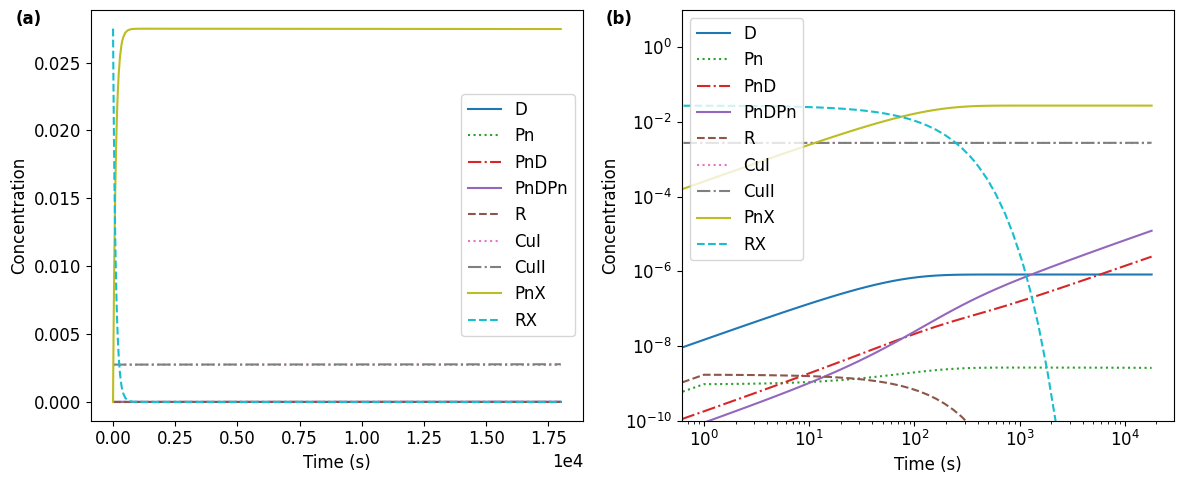

In [17]:
#@title { display-mode: "form" }

labels=['(a)','(b)','(c)']
i=0
fig1, axes = plt.subplots(1, 2, figsize=(12, 5))
for ax in axes:
     _ = result.plot(names=[k for k in rsys_orig.substances if k != 'CuIsour' \
                            and k != 'M' and k!= 'elec' and k != 'Cu0'], ax=ax)
     _ = ax.legend(loc='best',prop={'size': 12}) # Set the font size of the legend here.
     _ = ax.set_xlabel('Time (s)')
     _ = ax.set_ylabel('Concentration')
     _ = ax.text(-0.1, 1, labels[i], transform=ax.transAxes, fontweight='bold', va='top', ha='right')
     i+=1
axes[0].ticklabel_format(axis="x", style="sci", scilimits=(0,0))
_ = axes[1].set_ylim([1e-10, 1e1])
_ = axes[1].set_xscale('log')
_ = axes[1].set_yscale('log')
_ = fig1.tight_layout()

#### Meanings of the species produced during the polymerization

R: primary radical either from RX or from the thermal initiator  
D: termination product from primary radicals  
Pn: propagating polymer chain with a chain end radical  
PnD: dead polymer chain produced by termination through disproportionation  
PnDPn: dead polymer chain produced by termination through coupling  
PnX: dormant polymer chain with an active halogen chain-end  

### Monomer conversion vs time

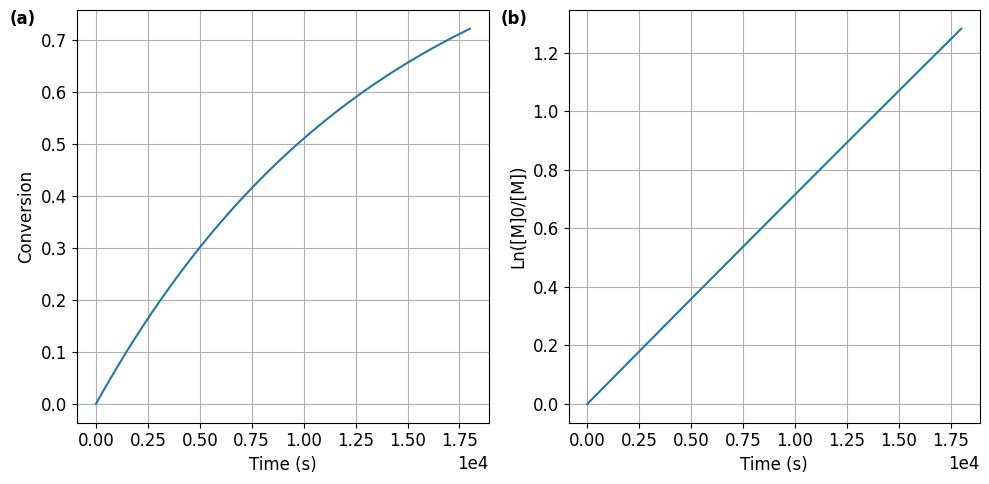

In [18]:
#@title { display-mode: "form" }

# Get concentrations and calculate conversion, Mn and Mw/Mn.
ConcM = result[1][:,result.odesys.names.index('M')]
ConcD = result[1][:,result.odesys.names.index('D')]
ConcPnD = result[1][:,result.odesys.names.index('PnD')]
ConcPnDPn = result[1][:,result.odesys.names.index('PnDPn')]
ConcPn = result[1][:,result.odesys.names.index('Pn')]
ConcM2_total = result[1][:,result.odesys.names.index('M2_total')]

if Poly_type != 'conven':
    ConcPnX = result[1][:,result.odesys.names.index('PnX')]
else:
    ConcPnX = np.zeros(len(result[0]))

ConvM =(ConcM[0]-ConcM)/ConcM[0]
LnM0_M = np.log(ConcM[0]/ConcM)

Mn = np.zeros(len(result[0]))
Mw = np.zeros(len(result[0]))
Mw_Mn = np.ones(len(result[0]))

Mn[1:] = (ConcM[0]-ConcM[1:])/(ConcPnX[1:] + ConcPnD[1:] + ConcPnDPn[1:] + ConcPn[1:])*MM
Mw[1:] = ConcM2_total[1:]/(ConcM[0]-ConcM[1:])*MM
Mw_Mn[1:] = Mw[1:]/Mn[1:]

# Get mole percent of end group loss, i.e., Tmol%.
if Poly_type != 'conven':
    x=result.odesys.names.index('RX')
    Tmol = 100*(ConcD + ConcPnD + 2*ConcPnDPn)/result[1][0,x]
else:
    Tmol = 100*np.ones(len(result[0]))

result_cal = [result[0],ConcM,ConvM,LnM0_M,Mn,Mw_Mn,Tmol]

# Monomer conversion vs. time and first order kinetic plots.
fig2, axes = plt.subplots(1, 2, figsize=(10, 5))
i=0
for ax in axes:
    ax.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
    _ = ax.plot(result_cal[0], result_cal[i+2])
    _ = ax.text(-0.1, 1, labels[i], transform=ax.transAxes, fontweight='bold', va='top', ha='right')
    _ = ax.grid()
    i += 1
_ = axes[0].set(xlabel = 'Time (s)', ylabel='Conversion')
_ = axes[1].set(xlabel = 'Time (s)', ylabel='Ln([M]0/[M])')
_ = fig2.tight_layout()

### Molecular weight, molecular weight distribution and mole percent loss of chain-ends.

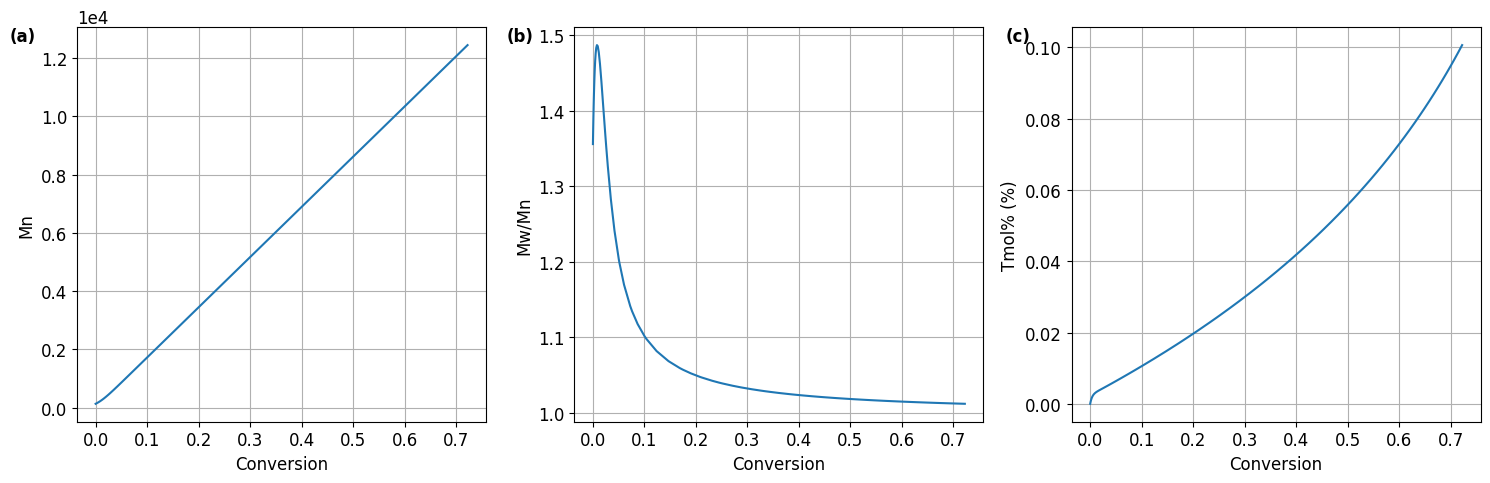

In [19]:
#@title { display-mode: "form" }

# Plot Mn, Mw/Mn and Tmol% vs. conversion.
fig3, axes = plt.subplots(1, 3, figsize=(15, 5))
i=0
for ax in axes:
    _ = ax.plot(result_cal[2][1:], result_cal[i+4][1:])
    _ = ax.text(-0.1, 1, labels[i], transform=ax.transAxes, fontweight='bold', va='top', ha='right')
    _ = ax.grid()
    i += 1
_ = axes[0].set(xlabel = 'Conversion', ylabel='Mn')
axes[0].ticklabel_format(axis="y", style="sci", scilimits=(0,0))
_ = axes[1].set(xlabel = 'Conversion', ylabel='Mw/Mn')
_ = axes[2].set(xlabel = 'Conversion', ylabel='Tmol% (%)')
_ = fig3.tight_layout()

if Poly_type == 'conven':
    print('Tmol% does not apply to conventional radical polymerization.')

Note: the meaning of mole percent loss of the chain end, i.e., $T_\text{mol%}$, can be found in the following article.[3] This calculated $T_\text{mol%}$ values could be significantly different from the experimental values because in the simulation only direct termination between two radicals is taken into account for the loss of chain-end functionalities, while other possible reactions causing the loss of chain ends, e.g., Cu(I) induced catalytic radical termination,[4] are not included.

[3]: Yu Wang, Mingjiang Zhong, Yaozhong Zhang, Andrew J. D. Magenau, and Krzysztof Matyjaszewski, Halogen Conservation in Atom Transfer Radical Polymerization, *Macromolecules* **2012**, *45*, 8929-8932, [DOI: 10.1021/ma3018958](https://doi.org/10.1021/ma3018958)  
[4]: Yu Wang, Nicolai Soerensen, Mingjiang Zhong, Hendrik Schroeder, Michael Buback, and Krzysztof Matyjaszewski,
Improving the “Livingness” of ATRP by Reducing Cu Catalyst Concentration, *Macromolecules* **2013**, *46*, 683-691, [DOI: 10.1021/ma3024393](https://doi.org/10.1021/ma3024393).

## Export the results

Export the result to a CSV file. If you run this program on your own computer, the CSV file is saved in the same folder as this ipynb file. If you run this program online using Google Colab, you can find the a menu bar on the left side. Click on the fourth one called "Files" and you will see the exported files.

In [20]:
#@title { display-mode: "form" }

now = datetime.datetime.now()
filename = f'{now.strftime("%Y-%m-%d-%Hh%Mm%Ss")}-ATRP-Simulation-{Poly_type}-{Monomer}-{Solvent}-{Ligand}-{Initiator}-{Temperature}C.csv'

with open(filename, 'w', newline='') as f:
    thewriter = csv.writer(f)
    for rxn in rsys_orig.rxns:
        thewriter.writerow([rxn])
    if Poly_type == 'conven' or Poly_type == 'icar':
        thewriter.writerow([f'The initiation efficiency of the thermal initiator is {f_TI}.'])
    for index, exp in enumerate(odesys.exprs):
        if odesys.names[index] != 'PR':
            thewriter.writerow([f'{odesys.names[index]}:',f'dy_{index}/dt = {exp}'])
    if Poly_type == 'conven':
        thewriter.writerow(['Tmol% does not apply to conventional radical polymerization.'])
    thewriter.writerow(['time (s)']+[k for k in rsys.substances if k != 'PR']+['conversion']+['ln([M]0/[M])']\
                       +['Mn']+['Mw/Mn']+['Tmol% (%)'])
    i=0
    for concen in result[1]:
        thewriter.writerow([result_cal[0][i]]+[concen[result.odesys.names.index(k)] for k in rsys.substances \
                                               if k != 'PR'] +[ConvM[i]]+[LnM0_M[i]]+[Mn[i]]+[Mw_Mn[i]]+[Tmol[i]])
        i+=1

Export the plots as pdf and png files.

In [21]:
#@title { display-mode: "form" }

fig1.savefig(f'{now.strftime("%Y-%m-%d-%Hh%Mm%Ss")}-concentration.pdf', bbox_inches='tight')
fig1.savefig(f'{now.strftime("%Y-%m-%d-%Hh%Mm%Ss")}-concentration.png', bbox_inches='tight', dpi=600)

fig2.savefig(f'{now.strftime("%Y-%m-%d-%Hh%Mm%Ss")}-conversion.pdf', bbox_inches='tight')
fig2.savefig(f'{now.strftime("%Y-%m-%d-%Hh%Mm%Ss")}-conversion.png', bbox_inches='tight', dpi=600)

fig3.savefig(f'{now.strftime("%Y-%m-%d-%Hh%Mm%Ss")}-molecular_weight.pdf', bbox_inches='tight')
fig3.savefig(f'{now.strftime("%Y-%m-%d-%Hh%Mm%Ss")}-molecular_weight.png', bbox_inches='tight', dpi=600)

-----------

In [22]:
#@title Copyright { display-mode: "form" }

from IPython.display import Markdown
import requests
copyright = requests.get("https://raw.githubusercontent.com/wangyu16/PolymerScienceEducation/master/copyright.md")
Markdown(copyright.text)

### MIT License  

Copyright (c) 2021 -- 2024 Yu Wang

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the “Software”), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED “AS IS”, WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.

### Contact

Dr. Yu Wang  
Department of Chemistry  
Institute for Materials Research and Innovation  
University of Louisiana at Lafayette  
Lafayette, LA 70504  
Email: yuwang@louisiana.edu

### Acknowledgement

This project is sponsored by National Science Foundation (NSF-2142043). 


In [23]:
# @title {display-mode: "form" }
links = requests.get("https://raw.githubusercontent.com/wangyu16/PolymerScienceEducation/refs/heads/master/links.md")
Markdown(links.text)

---

### Links

**[Home page of OVESET](https://wangyu16.github.io/PolymerScienceEducation/):** 

<img src="https://raw.githubusercontent.com/wangyu16/PolymerScienceEducation/refs/heads/master/img/QR_OVESET.svg" alt="OVESET Home Page" width="300">

**[Home page of Study Guide](https://hackmd.io/@YW2025/HJLiqoHRR)**

<img src="https://raw.githubusercontent.com/wangyu16/PolymerScienceEducation/refs/heads/master/img/QR_PolymerStudyGuide.svg" alt="Introduction to Polymer Science" width="300">

